# Assignment 4 - part 1
Lauri Pessi | bft860

## Dataset: municipal_key_figures.xlsx

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fetch data and take a peek
df = pd.read_excel('http://myy.haaga-helia.fi/~menetelmat/Data-analytiikka/Teaching/municipal_key_figures.xlsx')
m = int(df.shape[0])
print('Rows: ' + str(m))
print('Cols: ' + str(df.shape[1]))

Rows: 689
Cols: 33


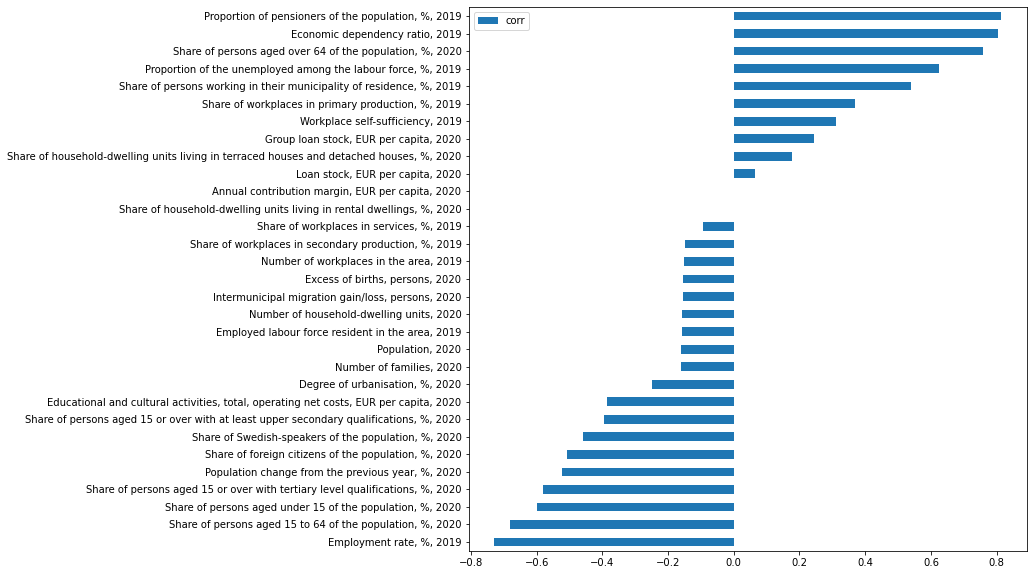

In [3]:
# Set dependent variable
y_name = 'Social and health care activities, total, operating net costs, EUR per capita, 2020'
y = df[y_name]


# Let's try selecting independent variables based on their correlation against y

# To avoid one-hotting etc. trickery with caterigorical variables, we'll just pick the numerics.
x_cands = df.drop(y_name, axis=1).select_dtypes(exclude='object').columns

# Calculate correlations against y for each
corrs = []
for c in x_cands:
    corrs.append(y.corr(df[c], method='pearson'))
   
dfc = pd.DataFrame({'x':x_cands, 'corr':corrs}, index=x_cands)

# And finally visualize the results
dfc.sort_values('corr').plot.barh(figsize=(10,10));

In [4]:
# Finally we can pick the strongly correlated variables based on their coefficent of +- 0.5  

x_names = dfc[(dfc['corr']>=0.5) | (dfc['corr']<=-0.5)].x
x = df[x_names]

print('Picked ' + str(x.shape[1]) + ' independent variables out of ' + str(x_cands.shape[0]) + ' candidates.')


Picked 11 independent variables out of 31 candidates.
